# Multi-class classification based on Softmax and Cross-Entropy using pytorch

## import libraries

In [1269]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits
from sklearn import datasets, model_selection
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib import cm
import os
%matplotlib inline 

## load data

In [1270]:
#directory_data  = './data/'
filename_data   = 'assignment_06_data.npz'
data            = np.load(os.path.join(filename_data))

x_train = data['x_train']
y_train = data['y_train']

x_test  = data['x_test']
y_test  = data['y_test']

num_data_train  = x_train.shape[0]
num_data_test   = x_test.shape[0]

print('*************************************************')
print('size of x_train :', x_train.shape)
print('size of y_train :', y_train.shape)
print('*************************************************')
print('size of x_test :', x_test.shape)
print('size of y_test :', y_test.shape)
print('*************************************************')
print('number of training image :', x_train.shape[0])
print('height of training image :', x_train.shape[1])
print('width of training image :', x_train.shape[2])
print('*************************************************')
print('number of testing image :', x_test.shape[0])
print('height of testing image :', x_test.shape[1])
print('width of testing image :', x_test.shape[2])
print('*************************************************')

*************************************************
size of x_train : (20000, 32, 32)
size of y_train : (20000,)
*************************************************
size of x_test : (8000, 32, 32)
size of y_test : (8000,)
*************************************************
number of training image : 20000
height of training image : 32
width of training image : 32
*************************************************
number of testing image : 8000
height of testing image : 32
width of testing image : 32
*************************************************


## number of classes

In [1263]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

## hyper-parameters

In [1264]:
# 설명변수를 정규화하고 변수에 대입하고 화면에 출력
mnist_data = mnist.data/255
# 데이터프레임 객체로 변환하고 화면에 출력
pd.DataFrame(mnist_data)

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## custom data loader for the PyTorch framework

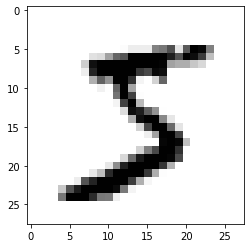

In [1249]:
#1번째 이미지를 화면에 출력
plt.imshow(mnist_data[0].reshape(28,28), cmap = cm.gray_r)
plt.show()

In [1250]:
# mnist data가 업데이트 되면서, label의 target value들이 모두 string type의 데이터형으로 변환되어 int로 형변환과정을 추가함
mnist_label = mnist.target
mnist_label = mnist_label.astype(int)
print(mnist_label.shape)

(70000,)


In [1251]:
#e데이터 집합을 훈련 데이터와 테스트 데이터로 분할
train_size = 5000
test_size = 500

train_x, test_x, train_y, test_y = model_selection.train_test_split(mnist_data, mnist_label, \
                                                                    train_size = train_size, test_size=test_size)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(5000, 784) (5000,)
(500, 784) (500,)


## shape of the data when using the data loader

In [1252]:
# 훈련데이터 텐서 변환
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()

# 테스트데이터 텐서 변환
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

# 변환된 텐서의 데이터 건수 확인
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)
# 설명변수와 목적변수 텐서를 합침
train = TensorDataset(train_x,train_y)

# 텐서의 첫 번째 데이터를 확인
print(train[0])

# 미니배치 분할
train_loader = DataLoader(train, batch_size= 100, shuffle= True)

torch.Size([5000, 784]) torch.Size([5000])
torch.Size([500, 784]) torch.Size([500])
(tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0

## class for the neural network 

In [1253]:
# 모형 설계
class Net(nn.Module) : 
    
    def __init__(self):
        super(Net, self).__init__()
        
        #입력층
        self.fc1 = nn.Linear(784,256)
        #중간층
        self.fc2 = nn.Linear(256,256)
        self.fc3 = nn.Linear(256,256)
        self.fc4 = nn.Linear(256,128)
        self.fc5 = nn.Linear(128,128)
        
        #출력층
        self.fc6 = nn.Linear(128,10)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.dropout(x, training=self.training)
        x = self.fc6(x)
        return F.log_softmax(x,dim =1)

# 인스턴스 생성
model =Net()

## build network

In [1266]:
%%time
print("{} \t {}".format("epoch", "total loss"))
print("----- \t ----------------------")

# 오차함수 객체
criterion = nn.CrossEntropyLoss()

# 최적화를 담당할 객체
optimizer = optim.SGD(model.parameters(), lr = 0.01)

# 학습시작
for epoch in tqdm(range(1000)):
    total_loss = 0
    for train_x, train_y in train_loader:
        
        # 계산 그래프 구성
        train_x, train_y = torch.autograd.Variable(train_x), torch.autograd.Variable(train_y)
        
        # 경사 초기화
        optimizer.zero_grad()
        
        # 순전파 계산
        output = model.forward(train_x)
        
        # 오차 계산
        loss = criterion(output,train_y)
        
        # 역전파 계산
        loss.backward()
        
        # 가중치 업데이트
        optimizer.step()
        
        # 누적 오차 계산
        total_loss += loss.data    
    if (epoch+1) % 20 == 0:
        print("{} \t {}".format((epoch+1)//20, total_loss))

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

epoch 	 total loss
----- 	 ----------------------


  2%|█▌                                                                              | 20/1000 [00:14<12:16,  1.33it/s]

1 	 0.055003829300403595


  4%|███▏                                                                            | 40/1000 [00:29<11:31,  1.39it/s]

2 	 0.027124863117933273


  6%|████▊                                                                           | 60/1000 [00:43<11:08,  1.41it/s]

3 	 0.047834623605012894


  8%|██████▍                                                                         | 80/1000 [00:57<11:26,  1.34it/s]

4 	 0.04009455442428589


 10%|███████▉                                                                       | 100/1000 [01:12<10:52,  1.38it/s]

5 	 0.03412574529647827


 11%|████████▍                                                                      | 107/1000 [01:17<10:44,  1.38it/s]


KeyboardInterrupt: 

In [1259]:
# 모델 평가

#계산 그래프 구성
test_x, test_y = torch.autograd.Variable(test_x), torch.autograd.Variable(test_y)

# 출력이 0 혹은 1이 되게 함
result = torch.max(model(test_x).data, dim = 1)[1]

# 모형의 정확도 측정
accuracy = sum(test_y.data.numpy() == result.numpy()) / len(test_y.data.numpy())
accuracy

0.888

## plot curve

In [1182]:
def plot_curve_error(data_mean, data_std, x_label, y_label, title):

    plt.figure(figsize=(8, 6))
    plt.title(title)

    alpha = 0.3
    
    plt.plot(range(len(data_mean)), data_mean, '-', color = 'red')
    plt.fill_between(range(len(data_mean)), data_mean - data_std, data_mean + data_std, facecolor = 'blue', alpha = alpha) 
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.tight_layout()
    plt.show()

In [1183]:
def print_curve(data, index):
    
    for i in range(len(index)):

        idx = index[i]
        val = data[idx]

        print('index = %2d, value = %12.10f' % (idx, val))

In [1184]:
def get_data_last(data, index_start):

    data_last = data[index_start:]

    return data_last

In [1185]:
def get_max_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.max()

    return value

In [1186]:
def get_min_last_range(data, index_start):

    data_range = get_data_last(data, index_start)
    value = data_range.min()

    return value

---

# functions for presenting the results

---

In [1187]:
def function_result_01():

    plot_curve_error(loss_mean_train, loss_std_train, 'epoch', 'loss', 'loss (training)')

In [1188]:
def function_result_02():

    plot_curve_error(accuracy_mean_train, accuracy_std_train, 'epoch', 'accuracy', 'accuracy (training)')

In [1189]:
def function_result_03():
    
    plot_curve_error(loss_mean_test, loss_std_test, 'epoch', 'loss', 'loss (testing)')

In [1190]:
def function_result_04():
    
    plot_curve_error(accuracy_mean_test, accuracy_std_test, 'epoch', 'accuracy', 'accuracy (testing)')

In [1191]:
def function_result_05():
    
    data_last = get_data_last(loss_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [1192]:
def function_result_06():
    
    data_last = get_data_last(accuracy_mean_train, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [1193]:
def function_result_07():
    
    data_last = get_data_last(loss_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [1194]:
def function_result_08():
    
    data_last = get_data_last(accuracy_mean_test, -10)
    index = np.arange(0, 10)
    print_curve(data_last, index)

In [1195]:
def function_result_09():
    
    value = get_max_last_range(accuracy_mean_train, -10)
    print('best training accuracy = %12.10f' % (value))

In [1196]:
def function_result_10():
    
    value = get_max_last_range(accuracy_mean_test, -10)
    print('best testing accuracy = %12.10f' % (value))

---

# RESULTS

---

## # 01. plot the training loss curve (mean, std)

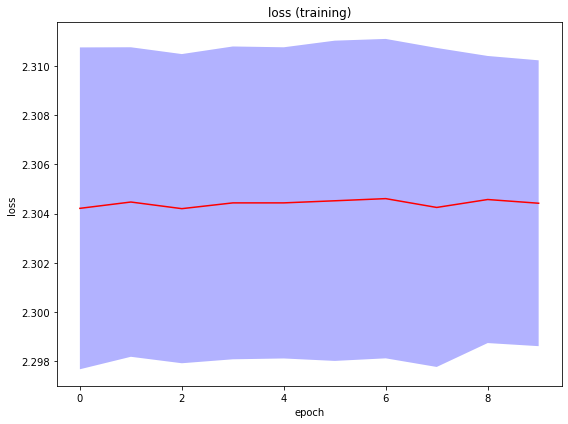

In [1197]:
function_result_01()

## # 02. plot the training accuracy curve (mean, std)

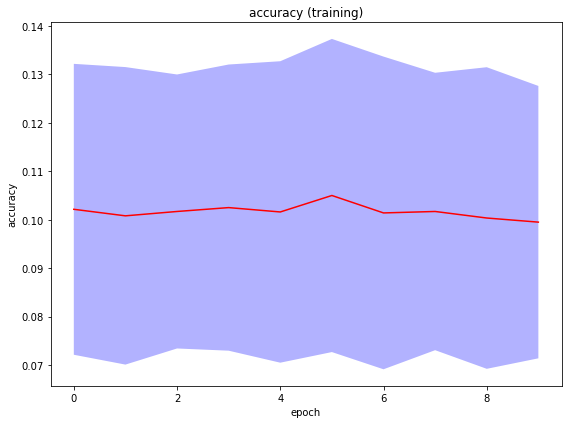

In [1161]:
function_result_02()

## # 03. plot the testing loss curve (mean, std)

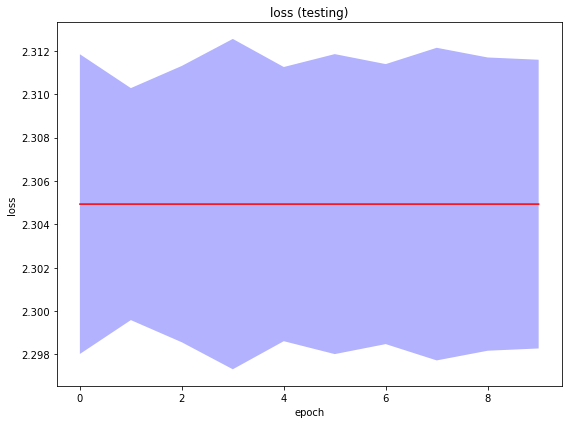

In [1162]:
function_result_03()

## # 04. plot the testing accuracy curve (mean, std)

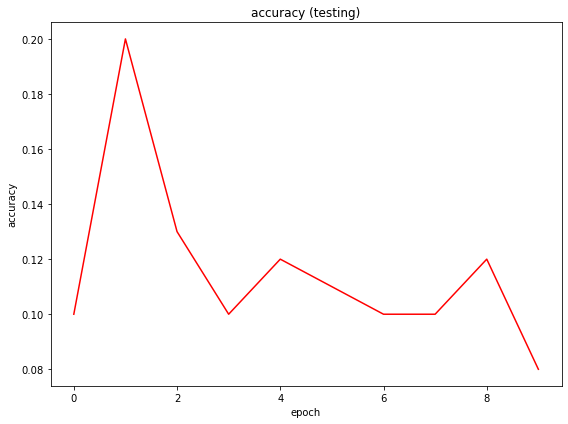

In [1163]:
function_result_04()

## # 05. print the training (mean) loss over batches at last 10 epochs

In [1117]:
function_result_05()

index =  0, value = 2.3047280514
index =  1, value = 2.3048352373
index =  2, value = 2.3048086727
index =  3, value = 2.3049140584
index =  4, value = 2.3045334625
index =  5, value = 2.3048085415
index =  6, value = 2.3046420240
index =  7, value = 2.3048294353
index =  8, value = 2.3048701096
index =  9, value = 2.3047512615


## # 06. print the training (mean) accuracy over batches at last 10 epochs

In [1118]:
function_result_06()

index =  0, value = 0.0979499974
index =  1, value = 0.0950999974
index =  2, value = 0.1002999973
index =  3, value = 0.0950999973
index =  4, value = 0.0989999972
index =  5, value = 0.0978499972
index =  6, value = 0.0971499975
index =  7, value = 0.0990499973
index =  8, value = 0.0972499972
index =  9, value = 0.0957999976


## # 07. print the testing (mean) loss over batches at last 10 epochs

In [1119]:
function_result_07()

index =  0, value = 2.3038569927
index =  1, value = 2.3038569778
index =  2, value = 2.3038569868
index =  3, value = 2.3038569480
index =  4, value = 2.3038569599
index =  5, value = 2.3038569719
index =  6, value = 2.3038569659
index =  7, value = 2.3038569778
index =  8, value = 2.3038569599
index =  9, value = 2.3038569599


## # 08. print the testing (mean) accuracy over batches at last 10 epochs

In [999]:
function_result_08()

index =  0, value = 0.0899999961
index =  1, value = 0.0899999961
index =  2, value = 0.0899999961
index =  3, value = 0.0899999961
index =  4, value = 0.1099999994
index =  5, value = 0.1199999973
index =  6, value = 0.1299999952
index =  7, value = 0.1099999994
index =  8, value = 0.1099999994
index =  9, value = 0.1099999994


## # 09. print the best training (mean) accuracy within the last 10 epochs

In [925]:
function_result_09()

best training accuracy = 0.1023999973


## # 10. print the best testing (mean) accuracy within the last 10 epochs

In [926]:
function_result_10()

best testing accuracy = 0.2800000012
